# Imported modules

In [1]:
# %%file intel_images_cls_modules.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
from torch.autograd import Variable

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import time
import os
import copy
import PIL
import cv2
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix, classification_report
import shutil
import glob
from zipfile import ZipFile
import seaborn as sns
import pandas as pd
import numpy as np
import random


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device= {device}')


torch.set_printoptions(linewidth=120)
print()
print('torch: ',torch.__version__)

Working on device= cpu

torch:  1.9.0+cu102


In [ ]:
# !pip install neptune-client
!pip install neptune-client torch torchvision

In [ ]:
import neptune.new as neptune
from neptune.new.types import File

run = neptune.init(project='armin.derencz/Intel-Image-Classification',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NGIyYzQ2My1iZjBhLTQ1MGQtYTJlMS04YmMxODBhNWVjYTUifQ==',
                   source_files=['*.py'])

# Kaggle data downloading

In [2]:
from google.colab import files
print("Please upload kaggle.json file.. \n")

upload = files.upload()

Please upload kaggle.json file.. 



Saving kaggle.json to kaggle.json


In [3]:
%%time
!pip install -U -q kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:06<00:00, 51.3MB/s]
100% 346M/346M [00:06<00:00, 60.1MB/s]
CPU times: user 91.1 ms, sys: 46 ms, total: 137 ms
Wall time: 11.1 s


# Classes preparing

In [4]:
# %%file data_wrangling.py

class DataWrangling:

  def __init__(self, path_to_zip_file):
    self.path_to_zip_file = path_to_zip_file

  def extract_archive(self):
    with ZipFile('intel-image-classification.zip', 'r') as zipobj:
      zipobj.extractall(path='data/')
      zipobj.close()

  def move_data_to_specific_dir(self, data_dir_path):
    for entry in os.scandir( data_dir_path ):
      if entry.is_dir():
        self.move_data_to_specific_dir(entry.path)
        path_to_data = glob.glob( entry.path + '/seg_*' )
        if path_to_data:
          if 'train' in path_to_data[0]:
            shutil.move( path_to_data[0], '/content/data/train/')

          elif 'test' in path_to_data[0]:
            shutil.move( path_to_data[0], '/content/data/val/')

          else:
            shutil.move( path_to_data[0], '/content/data/test/test/') # torchvision.datasets.ImageFolder expects subfolders
                                                                      # representing the classes containing images of the corresponding class.
  def del_directories(self, data_dir_path):
    dir_list_to_del = glob.glob( data_dir_path + '/seg_*' )
    [ shutil.rmtree(dir) for dir in dir_list_to_del ]

  def data_count(self, path):
    for self.entry in os.scandir( path= path ):
      if self.entry.is_dir():
        self.files_gen = ( self.image for self.image in os.listdir( self.entry.path ) )
        self.files_count = len( [ self.image for self.image in self.files_gen] )
        print( self.entry.name, self.files_count )

        if self.files_count >= 1:
          DataWrangling.data_count( self, path=self.entry.path )
    

In [27]:
# %%file image_preprocessing.py

class ImagePreprocessing:

  def __init__(self, dir_path):
    self.dir_path = dir_path
    self.counter = 0


  def __open_image_file(self, img):
    self.image_path = os.path.join( self.path, img )
    self.image = cv2.imread( self.image_path, cv2.IMREAD_UNCHANGED )
    self.image = cv2.cvtColor( self.image, cv2.COLOR_BGR2RGB)
    
  def image_size(self, class_name ):
    self.path = os.path.join( self.dir_path, class_name ) 
    self.files_gen = ( image for image in os.listdir( self.path ) )
    self.image = next( self.files_gen )
    self.__open_image_file( self.image )
    self.height, self.weight, _ = self.image.shape
    self.im_resolution = self.height, self.weight
    return self.im_resolution

  def __get_image_channels_as_array(self):
      self.__open_image_file( self.image )
      self.r_array, self.g_array, self.b_array  =  cv2.split( self.image )
      # convert to matrix
      # self.r_array, self.g_array, self.b_array  = np.asarray(self.r), np.asarray(self.g), np.asarray(self.b)
      return self.r_array, self.g_array, self.b_array 

  def __convert_to_float(self):
      # convert from int to float
      self.r_array, self.g_array, self.b_array = self.r_array.astype('float32'), self.g_array.astype('float32'), self.b_array.astype('float32')
      return self.r_array, self.g_array, self.b_array 

  def __normalize(self):
      # normalize to the range 0-1
      self.r_array /= 255.0
      self.g_array /= 255.0
      self.b_array /= 255.0
      return self.r_array, self.g_array, self.b_array 

  def __calculate_mean_and_std(self):
      # calculate mean
      self.r_array_mean, self.g_array_mean, self.b_array_mean = np.mean( self.r_array ), np.mean( self.g_array ), np.mean( self.b_array )
      # calculate std
      self.r_array_std, self.g_array_std, self.b_array_std = np.std( self.r_array ), np.std( self.g_array ), np.std( self.b_array )

  def __append_to_data_frame(self):
      param_dict = {  
                      'image'  : self.image_name,
                      'R_mean' : self.r_array_mean, 'G_mean' : self.g_array_mean, 'B_mean' : self.b_array_mean, 
                      'R_std'  : self.r_array_std,  'G_std'  : self.g_array_std,  'B_std'  : self.b_array_std  
                    }
      self.df = self.df.append( pd.DataFrame(param_dict, index=[0] ))     

  # /content/data/train   /content/data/train/buildings
  
  def get_mean_and_std_images(self, class_name ):
    self.df = pd.DataFrame() 
    self.path = os.path.join( self.dir_path, class_name ) 
    self.files_gen = ( self.image for self.image in os.listdir( self.path ) )
    for self.image in self.files_gen:
      self.image_name = self.image
      self.__get_image_channels_as_array()
      self.__convert_to_float()
      self.__normalize()
      self.__calculate_mean_and_std()
      self.__append_to_data_frame()
    self.df.reset_index( drop=True, inplace=True )
    return self.df

  def image_resize(self, folder_name, img_size ):

    self.files_gen = ( image for image in os.listdir( self.dir_path ) )
    self.width, self.height = image_size
    print(f'Resizing images to {self.width}x{self.height} pixels...')
    for self.counter, self.image in enumerate( self.files_gen ):
      self.file_path = os.path.join( self.path_to_folder, str(self.image) )
      self.__open_image_file( self.image )
      self.image = self.image.resize( img_size )
      self.image.save( fp=self.file_path, format='JPEG') 
      self.counter +=1
    print(f'{self.counter} files has been saved in directory')

  def visualize_n_random_images( self, number_of_images, no_rows, no_cols, set_figsize, class_name, save_to_path):
    self.i = 1
    self.images_no = number_of_images
    self.cols = no_cols
    self.rows = no_rows
    self.path = os.path.join( self.dir_path, class_name )
    self.files_gen = ( image for image in os.listdir( self.path ) )
    self.random_images = random.choices( list(self.files_gen), k=self.images_no )


    fig = plt.figure( figsize= set_figsize  )
    for self.image in self.random_images:
      self.image_name = self.image
      self.ax = fig.add_subplot( self.rows, self.cols, self.i)      
      self.__open_image_file( self.image )
      plt.imshow( self.image )  
      plt.axis('off')
      self.ax.set_title( self.image_name, color= 'green', fontweight='bold')
      fig.tight_layout()
      self.i+=1
    plt.savefig( save_to_path )

# Pathes to directory

In [6]:
path_to_zip = '/content/intel-image-classification.zip'

dir_path = '/content/data/'


class_names = [ 'buildings', 'forest', 'glacier', 'mountain', 'sea', 'street' ]

builiding_class = class_names[0]
forest_class    = class_names[1]
glacier_class   = class_names[2]
mountain_class  = class_names[3]
sea_class       = class_names[4]
street_class    = class_names[5]

# Instances declaration

In [7]:
# from image_preprocessing import ImagePreprocessing
data_wrangling_obj = DataWrangling( path_to_zip )

In [28]:
train_data = '/content/data/train'

train_images = ImagePreprocessing( dir_path=train_data)


# Data wrangling

In [9]:
data_wrangling_obj.extract_archive()
data_wrangling_obj.move_data_to_specific_dir( data_dir_path=dir_path )
data_wrangling_obj.del_directories( data_dir_path=dir_path )

In [10]:
data_wrangling_obj.data_count( path=dir_path)

train 6
street 2382
mountain 2512
forest 2271
buildings 2191
sea 2274
glacier 2404
val 6
street 501
mountain 525
forest 474
buildings 437
sea 510
glacier 553
test 1
test 7301


In [19]:
train_images.image_size( class_name=builiding_class ) 

(150, 150)

# Mean, STD, for each class and set

In [24]:
train_building_imgs_df   = train_images.get_mean_and_std_images( class_name=builiding_class )
train_forest_imgs_df    = train_images.get_mean_and_std_images( class_name=forest_class )
train_glacier_imgs_df   = train_images.get_mean_and_std_images( class_name=glacier_class )
train_mountain_imgs_df  = train_images.get_mean_and_std_images( class_name=mountain_class )
train_sea_imgs_df       = train_images.get_mean_and_std_images( class_name=sea_class )
train_street_imgs_df    = train_images.get_mean_and_std_images( class_name=street_class )

In [25]:
train_building_imgs_df

image    R_mean    G_mean    B_mean     R_std     G_std     B_std
0     13191.jpg  0.350473  0.469608  0.555303  0.217107  0.226447  0.261455
1     18602.jpg  0.560190  0.547825  0.519955  0.248461  0.252527  0.276224
2      1684.jpg  0.442039  0.456220  0.423005  0.251024  0.243343  0.255004
3      4244.jpg  0.575682  0.528325  0.503166  0.220102  0.192393  0.194951
4      6685.jpg  0.778546  0.780182  0.767923  0.244188  0.212793  0.194064
...         ...       ...       ...       ...       ...       ...       ...
2186   3000.jpg  0.299829  0.326699  0.339254  0.271856  0.257140  0.234650
2187  13315.jpg  0.423975  0.555716  0.625410  0.215494  0.246635  0.295144
2188   3336.jpg  0.524842  0.517829  0.487138  0.264329  0.255404  0.300187
2189   9281.jpg  0.623545  0.581671  0.527480  0.305195  0.322227  0.319345
2190   8418.jpg  0.523435  0.516552  0.491487  0.288109  0.289496  0.292876

[2191 rows x 7 columns]

In [26]:
train_forest_imgs_df

image    R_mean    G_mean    B_mean     R_std     G_std     B_std
0     18123.jpg  0.259701  0.318111  0.142906  0.228359  0.234299  0.185358
1     12664.jpg  0.290228  0.280657  0.214274  0.205555  0.203433  0.214576
2     19747.jpg  0.419971  0.407226  0.364083  0.256406  0.249528  0.231094
3      7479.jpg  0.403961  0.369789  0.371959  0.218631  0.215299  0.211260
4      9104.jpg  0.134750  0.332888  0.078930  0.152891  0.185890  0.116160
...         ...       ...       ...       ...       ...       ...       ...
2266   3959.jpg  0.542084  0.525089  0.397674  0.299293  0.296394  0.304555
2267   5816.jpg  0.359399  0.530048  0.184796  0.184238  0.271957  0.136793
2268   3102.jpg  0.245023  0.246147  0.136052  0.219641  0.219577  0.154628
2269  15531.jpg  0.183118  0.306654  0.214981  0.216231  0.217179  0.202099
2270   7629.jpg  0.124392  0.300330  0.241441  0.119787  0.201262  0.160372

[2271 rows x 7 columns]

In [ ]:
train_forest_imgs_df

In [ ]:
train_glacier_imgs_df

In [ ]:
train_mountain_imgs_df

In [ ]:
train_sea_imgs_df

In [ ]:
train_street_imgs_df

In [ ]:
# Pandas DataFrame 
run['data/train_building_images_channels_mean_std'].upload(File.as_html( train_building_imgs_df ))
run['data/train_forest_images_channels_mean_std'].upload(File.as_html( train_forest_imgs_df ))
run['data/train_glacier_images_channels_mean_std'].upload(File.as_html( train_glacier_imgs_df ))
run['data/train_mountain_images_channels_mean_std'].upload(File.as_html( train_mountain_imgs_df ))
run['data/train_sea_images_channels_mean_std'].upload(File.as_html( train_sea_imgs_df ))
run['data/train_street_images_channels_mean_std'].upload(File.as_html( train_street_imgs_df ))


# Images presentation

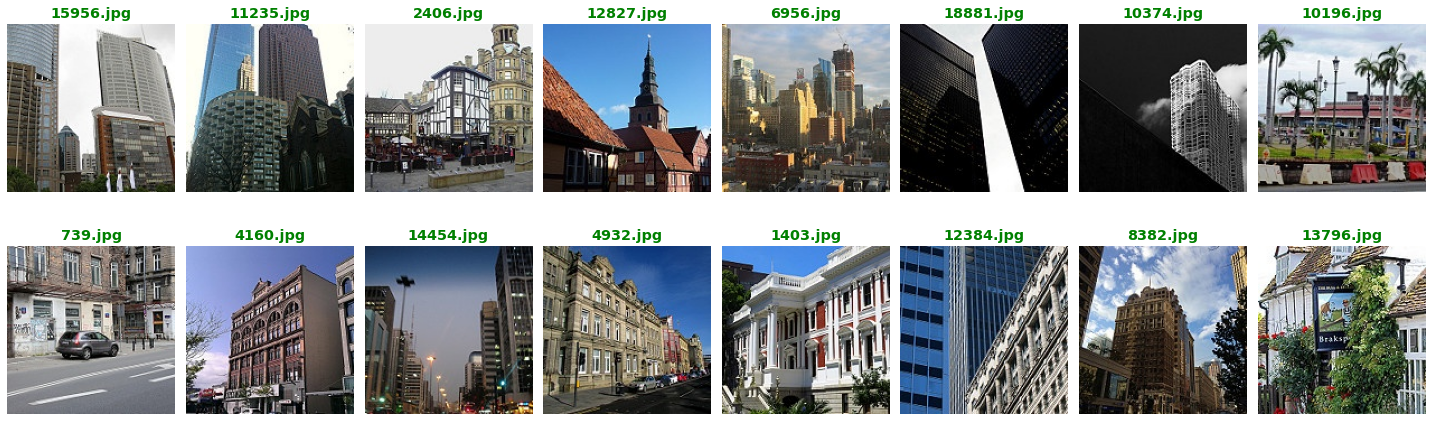

In [30]:
number_of_images=16
no_rows= 2
no_cols= 8
set_figsize= (20,8)

class_name= builiding_class
save_path ='./data/examples_of_buildings_images.jpg'


# number_of_images, no_rows, no_cols, set_figsize, img_name, set_dir, class_name, save_to_path

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

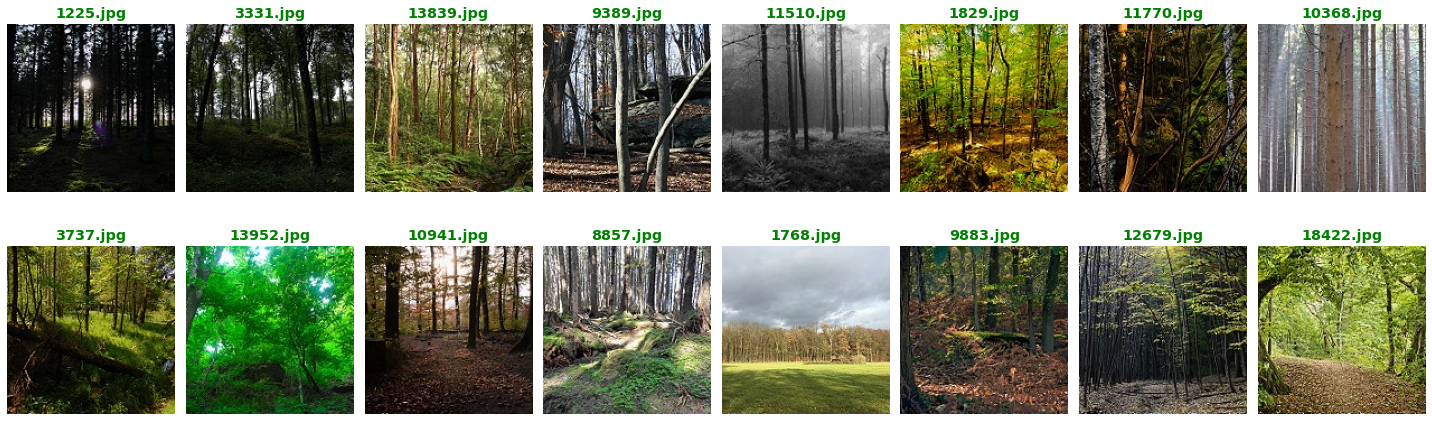

In [31]:
class_name= forest_class
save_path ='./data/examples_of_forest_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

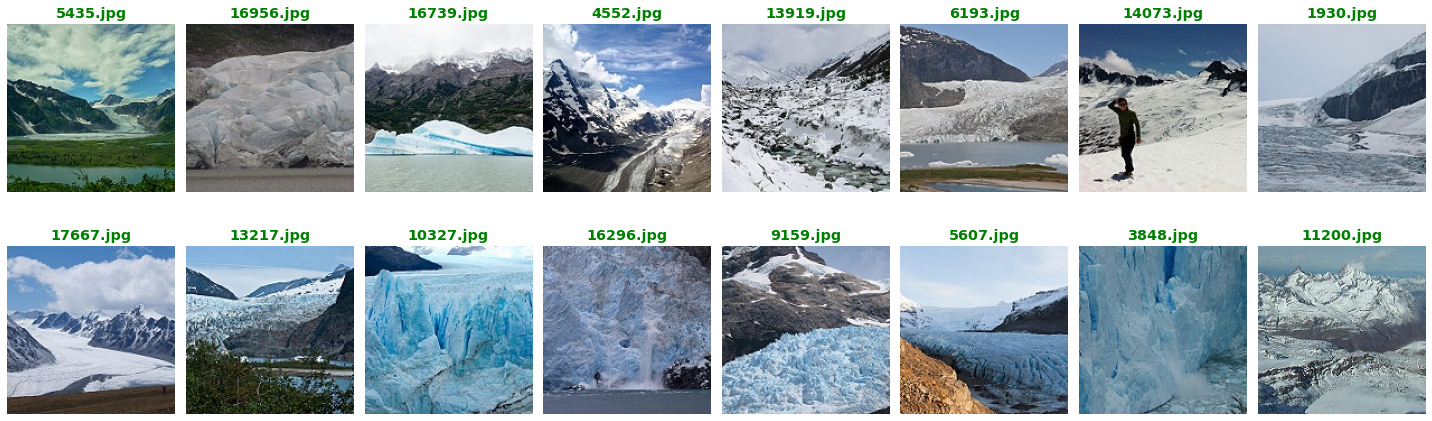

In [32]:
class_name= glacier_class
save_path ='./data/examples_of_glacier_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

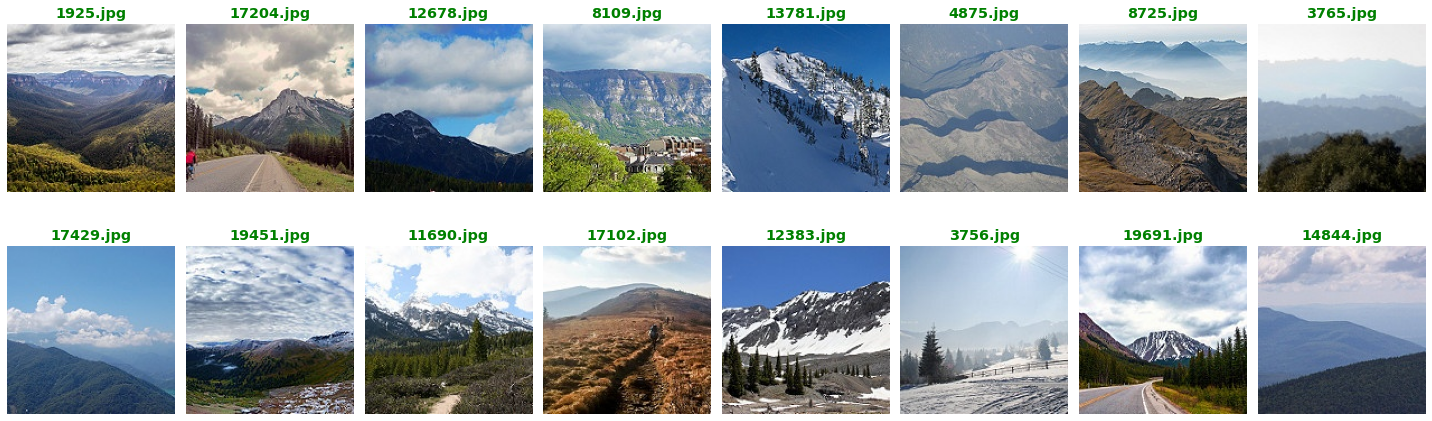

In [33]:
class_name= mountain_class
save_path ='./data/examples_of_mountain_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

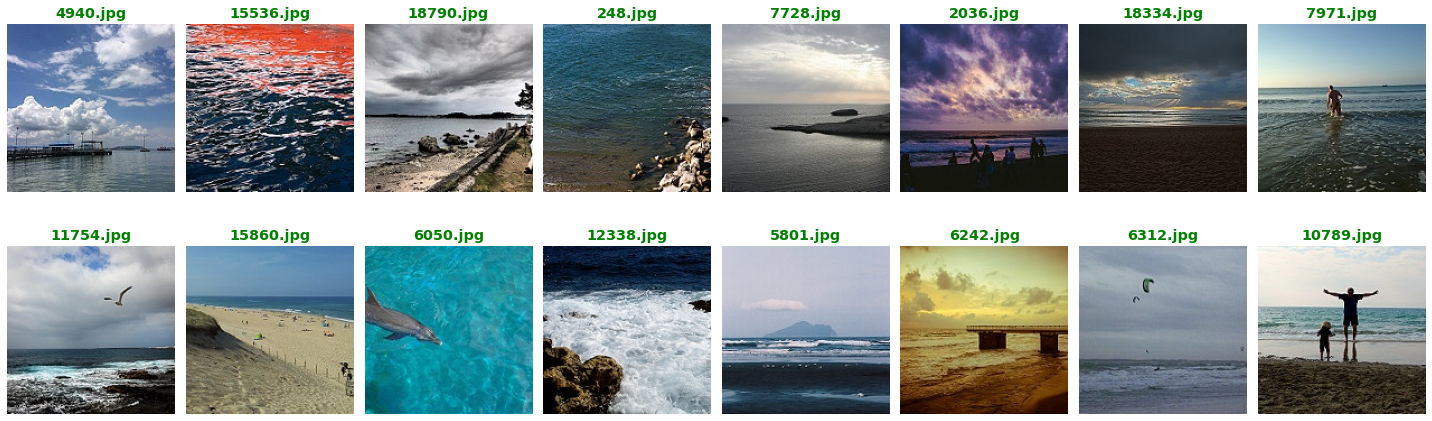

In [34]:
class_name= sea_class
save_path ='./data/examples_of_sea_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

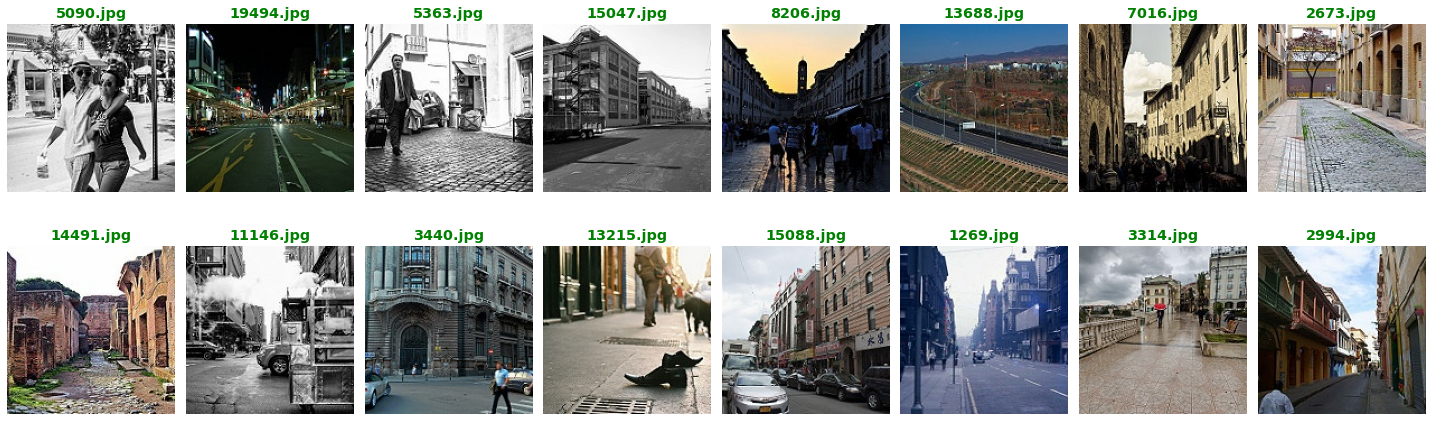

In [35]:
class_name= street_class
save_path ='./data/examples_of_street_images.jpg'

train_images.visualize_n_random_images( number_of_images, no_rows, no_cols, set_figsize,
                                        class_name, save_to_path=save_path )

In [ ]:
run['images/train/examples_of_buildings_images'].upload('./data/examples_of_buildings_images.jpg')
run['images/train/examples_of_forest_images'].upload('./data/examples_of_forest_images.jpg')
run['images/train/examples_of_glacier_images'].upload('./data/examples_of_glacier_images.jpg')
run['images/train/examples_of_mountain_images'].upload('./data/examples_of_mountain_images.jpg')
run['images/train/examples_of_sea_images'].upload('./data/examples_of_sea_images.jpg')
run['images/train/examples_of_street_images'].upload('./data/examples_of_street_images.jpg')

In [12]:
# %%file data_transforms.py

mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomHorizontalFlip()
    ]),
    'val': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])  
}

# run['config/dataset/transforms'] = data_transforms

In [13]:
# import
data_dir = 'data'
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders    = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# This Data contains around 25k images of size 150x150 distributed under 6 categories.
# {'buildings' -> 0,
# 'forest' -> 1,
# 'glacier' -> 2,
# 'mountain' -> 3,
# 'sea' -> 4,
# 'street' -> 5 }

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure( figsize= ( 10, 8 )  )
    plt.imshow(inp)
   
    plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape, classes.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

img_exmp = imshow(out, title=[class_names[x] for x in classes])
# plt.imsave('img_exmp.jpg', img_exmp)

In [ ]:
# Opdpowiedź dlaczego jest  16*5*5 w __init__ fc1
conv1 = nn.Conv2d( in_channels=3, out_channels=12, kernel_size=5, stride=1 )
pool1 = nn.MaxPool2d(2, 2)   # 2x2 - kernel size, 2 - stride
conv2 = nn.Conv2d( in_channels=12, out_channels=20, kernel_size=3, stride=1 )
pool2 = nn.MaxPool2d(2, 2)
conv3 = nn.Conv2d( in_channels=20, out_channels=32, kernel_size=3, stride=1 )
pool3 = nn.MaxPool2d(2, 2)
    

print('Wzór: ( W -F + 2P)/S + 1')
print('example: 5x5 input, 3x3 filter, padding=0, stride=1')
print('(5-3 + 0)/1+1 = 2/1 +1 = 3 -> 3x3')
print()
print(f'{inputs.shape} -  4 batch size, 3 color channel, 150*150 image size')
print()

x = conv1( inputs )
print(f'{x.shape} - ze wzoru: ( 150 - 5 + 0 )/1 + 1 = 146 -> 146x146') 
x = pool1(x)
print(f'{x.shape} - ze wzoru: ( 146 - 2 + 0 )/2 + 1 = 73 -> 73x73 po pierwszym maxPool')  
x = conv2(x)
print(f'{x.shape} - ze wzoru: ( 73 - 3 + 0 )/1 + 1 = 71 -> 71x71') 
x = pool2(x)
print(f'{x.shape} - ze wzoru: ( 71 - 2 + 0 )/2 + 1 = 35 -> 35x35 po drugim maxPool')
x = conv3(x)
print(f'{x.shape} - ze wzoru: ( 35 - 3 + 0 )/1 + 1 = 33 -> 33x33')
x = pool2(x)
print(f'{x.shape} - ze wzoru: ( 33 - 2 + 0 )/2 + 1 = 16 -> 16x16 po trzecim maxPool')

print()
print('Na końcu chcemy otrzymać 1D wektor, dlatego mnożymy 32*16*16')

In [14]:
# %%file model.py 
class ConvNet(nn.Module):
  def __init__(self):  
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d( in_channels=3, out_channels=12, kernel_size=5, stride=1 )
        self.pool1 = nn.MaxPool2d(2, 2)  # 2x2 - kernel size, 2 - stride 
        self.conv2 = nn.Conv2d( in_channels=12, out_channels=20, kernel_size=3, stride=1 )
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.conv3 = nn.Conv2d( in_channels=20, out_channels=32, kernel_size=3, stride=1 )
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 120) # input size - 16*7*7, output size - 120
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 6) 


  def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool1(F.relu(self.conv1(x)))  # -> n, 6, 18, 18
        x = self.pool2(F.relu(self.conv2(x)))  # -> n, 16, 7, 7
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 32*16*16)            # -> n, 784 ( musimy wszystko spłaszczyć)
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

In [15]:
dataloaders.keys()

dict_keys(['train', 'val'])

In [ ]:
# Hyperparameters
input_size = 150*150
num_classes = 6
learning_rate = 0.001
batch_size = 100
num_epochs = 30


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# run['config/dataset/train_dataset'].track_files("./content/data/train")
# run['config/dataset/val_dataset'].track_files("./content/data/val")
# run['config/dataset/test_dataset'].track_files("./content/data/test")

In [ ]:
hparams = {"learning_rate"  : learning_rate,
          "optimizer"      : type(optimizer).__name__,
          "criterion"      : type(criterion).__name__,
          "batch_size"     : batch_size,
          "n_epochs"       : num_epochs,
          "Input_size"    : "150 x 150",
          "n_classes" : num_classes,
          'metrics': ['accuracy']
          }


run["config/parameters"] = hparams
run['config/model'] = type(model).__name__

In [ ]:
print( model.conv1.weight.shape)
print( model.conv2.weight.shape )
print( model.conv3.weight.shape )

In [ ]:
summary(model, input_size=( 3, 150, 150 ) )

# model test

In [ ]:
# def get_num_correct(preds, labels):
#     return preds.argmax(dim=1).eq(labels).sum().item()

In [ ]:
# train_loader = dataloaders['train']
# val_loader = dataloaders['val']


# for epoch in range(10):

#     total_loss = 0
#     total_correct = 0

#     for batch in train_loader: # Get Batch
#         images, labels = batch 
#         images = images.to(device)
#         labels = labels.to(device)

#         preds = model(images) # Pass Batch
#         loss = F.cross_entropy(preds, labels) # Calculate Loss

#         optimizer.zero_grad()
#         loss.backward() # Calculate Gradients
#         optimizer.step() # Update Weights

#         total_loss += loss.item()
#         total_correct += get_num_correct(preds, labels)

#     print(
#         "epoch", epoch, 
#         "total_correct:", total_correct, 
#         "loss:", total_loss
#     )

# model function

In [ ]:
# %%file train_function.py

def train_model( model, criterion, optimizer, num_epochs) :
    start = time.time()
    best_accuracy = 0.0
    global metrics_df 
    metrics_df = pd.DataFrame()

    for epoch in range(num_epochs):
        epochs_list.append( epoch + 1 )
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 15)
        
        # Each epoch has a training and validation phase
        for phase in dataloaders.keys():
            running_loss = 0.0
            running_corrects = 0

            if phase == 'train':
                model.train()  # Set model to training model
            else:
                model.eval()   # Set model to evaluate model


            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward and optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward() # calculate gradients
                        optimizer.step() # update weights

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.double() / dataset_sizes[phase]
            

            print(f'{phase} -  Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')       

            if phase == 'train':
              train_loss_list.append(epoch_loss)
              train_acc_list.append(epoch_accuracy.item())

              run["metrics/training/batch/loss"].log(loss)
              run["metrics/training/batch/acc"].log(epoch_accuracy.item())
            
            else:
              val_loss_list.append(epoch_loss)
              val_acc_list.append(epoch_accuracy.item()) 

              run["metrics/validation/batch/loss"].log(loss)
              run["metrics/validation/batch/acc"].log(epoch_accuracy.item())
            
            # deep copy the model
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
        print()

    # np.column_stack rather than zip as in your first attempt, this has around a 2x speedup
    metrics_df = pd.DataFrame(np.column_stack([ epochs_list, train_loss_list, val_loss_list, train_acc_list, val_acc_list ]), 
                              columns=['epoch', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])
    
    # metrics_df = pd.DataFrame( { 'train_loss' : train_loss_list, 'val_loss'   : val_loss_list,
    #                              'train_acc'  : train_acc_list, 'val_acc'    : val_acc_list } )
    
    metrics_df.reset_index(drop=True, inplace=True)

    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print('Best val Acc: {:4f}'.format(best_accuracy))

    return model

In [ ]:
train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

epochs_list = []



model = train_model(model, criterion, optimizer, num_epochs)

In [ ]:
metrics_df

In [ ]:
# Pandas DataFrame 
run['metrics/train_val_loss_acc'].upload(File.as_html(metrics_df))

In [ ]:
# save the trained model to disk
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './model.pth')


# run['model_checkpoints/model'].upload('./model.pth')


In [ ]:
# # save the trained model to disk
# torch.save({
#             'epoch': num_epochs,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': criterion,
#             }, '/content/drive/MyDrive/ColabNotebooks/intel_image/model.pth')

In [ ]:
fig, ax= plt.subplots(1, 2, figsize=( 23, 6 ) )

sns.lineplot( data=metrics_df, y='train_loss', x='epoch', label='train loss', ax=ax[0])
sns.lineplot( data=metrics_df, y='val_loss', x='epoch', label='val loss', ax=ax[0])

sns.lineplot( data=metrics_df, y='train_acc', label='train acc', x='epoch', ax=ax[1])
sns.lineplot( data=metrics_df, y='val_acc', x='epoch', label='val acc', ax=ax[1])

ax[0].set( xlabel='epochs', ylabel='train')
ax[1].set( xlabel='epochs', ylabel='accuracy')

fig.savefig("metrics.jpg")


plt.show()

In [ ]:
run['visual/acc_loss-fig'].upload(fig)

In [ ]:
run.stop()

# Model load

In [44]:
model = ConvNet()
model.load_state_dict( torch.load('/content/drive/MyDrive/ColabNotebooks/intel_image/model.pth')['model_state_dict'] )

<All keys matched successfully>

In [45]:
next(model.parameters()).is_cuda

False

In [46]:
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [47]:
next(model.parameters()).is_cuda

True

# confusion matrix

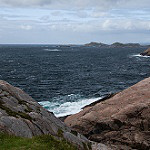

In [67]:
image

In [59]:
predicted_label = 0

In [68]:
image=PIL.Image.open('/content/data/val/sea/20115.jpg')
    
image_tensor=data_transforms['val'](image).float()
image_tensor=image_tensor.unsqueeze_(0)
input=Variable(image_tensor)
input = input.to(device)
       
output_tensor = model(input)
predicted_values_tensor = output_tensor.data
predicted_values_ndarray = predicted_values_tensor.cpu().numpy()
index_of_max_values = predicted_values_ndarray.argmax()




predicted_label=class_names[index_of_max_values]
    
print( index_with_max_values )

print(class_names)
print( predicted_label)

3
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
mountain


In [65]:
prediction( '/content/data/val/sea/20115.jpg', data_transforms['test'] )

'mountain'

In [71]:
data_transforms['test'](image)

tensor([[[ 0.8863,  0.8392,  0.7922,  ...,  0.7137,  0.7137,  0.6980],
         [ 0.8863,  0.8078,  0.7451,  ...,  0.6824,  0.6667,  0.6667],
         [ 0.9020,  0.8549,  0.8235,  ...,  0.6510,  0.6510,  0.6510],
         ...,
         [-1.1843, -1.2314, -1.3412,  ..., -1.8588, -1.6863, -1.6863],
         [-1.1529, -1.1529, -1.2784,  ..., -1.7647, -1.9216, -1.6235],
         [-1.1843, -1.0745, -1.2314,  ..., -1.7490, -1.7804, -1.1686]],

        [[ 1.0745,  1.0275,  0.9804,  ...,  0.9804,  0.9804,  0.9490],
         [ 1.0745,  0.9961,  0.9333,  ...,  0.9490,  0.9333,  0.9176],
         [ 1.0902,  1.0431,  1.0118,  ...,  0.9176,  0.9176,  0.9020],
         ...,
         [-1.0431, -1.0431, -1.1373,  ..., -1.9686, -1.7961, -1.7961],
         [-1.0118, -0.9647, -1.0588,  ..., -1.8431, -2.0000, -1.7020],
         [-1.0588, -0.9333, -1.0431,  ..., -1.7961, -1.8275, -1.2157]],

        [[ 1.3255,  1.2784,  1.2314,  ...,  1.2941,  1.2941,  1.3098],
         [ 1.3255,  1.2471,  1.1843,  ...,  1

In [72]:
data_transforms['test'](image).float()

tensor([[[ 0.8863,  0.8392,  0.7922,  ...,  0.7137,  0.7137,  0.6980],
         [ 0.8863,  0.8078,  0.7451,  ...,  0.6824,  0.6667,  0.6667],
         [ 0.9020,  0.8549,  0.8235,  ...,  0.6510,  0.6510,  0.6510],
         ...,
         [-1.1843, -1.2314, -1.3412,  ..., -1.8588, -1.6863, -1.6863],
         [-1.1529, -1.1529, -1.2784,  ..., -1.7647, -1.9216, -1.6235],
         [-1.1843, -1.0745, -1.2314,  ..., -1.7490, -1.7804, -1.1686]],

        [[ 1.0745,  1.0275,  0.9804,  ...,  0.9804,  0.9804,  0.9490],
         [ 1.0745,  0.9961,  0.9333,  ...,  0.9490,  0.9333,  0.9176],
         [ 1.0902,  1.0431,  1.0118,  ...,  0.9176,  0.9176,  0.9020],
         ...,
         [-1.0431, -1.0431, -1.1373,  ..., -1.9686, -1.7961, -1.7961],
         [-1.0118, -0.9647, -1.0588,  ..., -1.8431, -2.0000, -1.7020],
         [-1.0588, -0.9333, -1.0431,  ..., -1.7961, -1.8275, -1.2157]],

        [[ 1.3255,  1.2784,  1.2314,  ...,  1.2941,  1.2941,  1.3098],
         [ 1.3255,  1.2471,  1.1843,  ...,  1

In [51]:
}def prediction(img_path,transformer):
    
    image=PIL.Image.open(img_path)
    
    image_tensor=transformer(image).float()
    image_tensor=image_tensor.unsqueeze_(0)
    input=Variable(image_tensor)
    input = input.to(device)
       
    output=model(input)
    index=output.data.cpu().numpy().argmax()
    
    pred=class_names[index]
    
    return pred



In [ ]:
test_dir = '/content/data/test/test'

images_path=glob.glob( os.path.join( test_dir, '*.jpg') )

In [ ]:
pred_dict={}

for i in images_path:
    pred_dict[ i [ i.rfind('/')+1 : ] ]= prediction(i, transformer=data_transforms['test'])



In [ ]:
pred_dict.items()

In [ ]:
files_gen = ( image for image in images_path  )

In [ ]:


image = cv2.imread( next( files_gen ) )
print( image.shape )
print( next( files_gen ) )
cv2_imshow( image, )

In [ ]:
resize = cv2.resize(image, (0, 0), fx=2, fy=2 ) # 35% oryginalengo rozmiaru
print(f'Original image shape: {image.shape}' )
print(f'Resized image shape: {resize.shape}' )
cv2_imshow( resize )

In [ ]:
# Adding the text using putText() function
text = cv2.putText( resize,
                   'opis',
                   (50, 12),  # Bottom-left corner co-ordinates, from where the text should start
                   cv2.FONT_HERSHEY_SIMPLEX, # font
                   0.5,                        # font size
                   (255, 0, 0),
                   2)

cv2_imshow( text )

In [ ]:
valloader = dataloaders['val']
valloader

In [ ]:
len( valloader )

In [ ]:
dataiter = iter( valloader )
images, labels = dataiter.next()

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d val images: %d %%' % (len(valloader),100 * correct / total))

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in valloader:
        inputs = inputs.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


In [ ]:
image_datasets['val'].class_to_idx

In [ ]:
# constant for classes
classes = image_datasets['val'].classes

# Build confusion matrix
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 5))

cm_image = sns.heatmap( cm, annot=True, fmt='d', linewidth=.2, cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 15})
cm_image.tick_params(labelsize=15)
cm_image.xaxis.tick_top()
plt.yticks(rotation=0) 
plt.xticks(rotation=0)

cm_image = cm_image.get_figure()

plt.show()

In [ ]:
cm_image.savefig("confusion_matrix.jpg", bbox_inches='tight')

run['visual/confusion_matrix'].upload( cm_image )

In [ ]:
cls_report = classification_report(y_true, y_pred, target_names=classes)

print( cls_report )

In [ ]:
cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

cls_report_df = pd.DataFrame( cls_report ).transpose()

cls_report_df

In [ ]:
run['metrics/classification_report'].upload(File.as_html( cls_report_df ))

In [ ]:
run.stop()